# Getting `twopoppy` results

You need to **clone** (not download) the `twopoppy code`:

    git clone https://github.com/birnstiel/two-pop-py
    
Then go in the repository and install it e.g. with

    pip install -e .

This Notebook has two parts, the first one loads the simulation and calculates the size distribution, intensity profile, and from that the characteristic radius and fluxes at different wavelengths.

In another script `load_grid`, I already did this for the entire grid, saving only the parameters, $R_\mathrm{eff}$, and $F_\nu$ in the table `results_table.dat`. The second script reads those results and displays them.

## Part 1: calculate everything for one simulation

All the imports and setup stuff:

In [1]:
import twopoppy
from planck_B_nu import planck_B_nu

import sys
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy import constants as c
from astropy import units as u

from scipy.signal     import savgol_filter
from scipy.integrate import cumtrapz

from IPython.display import Markdown

c_light = c.c.cgs.value
au = u.au.to('cm')
pc = u.pc.to('cm')
M_sun = c.M_sun.cgs.value
year = u.year.to('s')
arcsec_sq = (u.arcsec**2).to(u.sr) # arcsec**2 in steradian

%matplotlib inline
plt.style.use({'figure.dpi':200})

Then load the results from the file (this takes a while):

In [2]:
RESULTS=twopoppy.wrapper.load_grid_results('v3_stick.pbz2')

Loading pbz2-file 'v3_stick.pbz2' ... Done!


Get the lists of parameters and print them

In [3]:
par_names = ['alpha','mstar','vfrag','estick','rc']
par_units = [[1,'-'],[M_sun,'M_sun'],[1e2,'m/s'],[1,'-'],[au,'au']]

# collect every parameter set for each simulation

params = []
for res in RESULTS:
    p = []
    for param in par_names:
        p += [getattr(res.args,param)]
    params += [p]

# keep only the unique values
    
params = np.array(params)
params = [set(p) for p in params.T]

# print them

for name,values,unit in zip(par_names,params,par_units):
    print('{:<7}= '.format(name)+', '.join(['{:.3g}'.format(v/unit[0]) for v in sorted(values)])+ ' [{}]'.format(unit[1])) 

alpha  = 0.0001, 0.001, 0.01 [-]
mstar  = 1.3 [M_sun]
vfrag  = 1, 5, 10 [m/s]
estick = 0.1, 0.5, 1 [-]
rc     = 20, 40, 100, 200, 300 [au]


`RESULTS` is a long un-ordered list of simulation results objects, so you need to find the one you want yourself. Specify the desired parameters here:

In [4]:
sample_rc = 20*au
sample_alpha = 0.01
sample_vfrag = 1000
sample_mratio = 0.05
sample_estick = 1
sample_mstar = 1.3*M_sun
sample_time = 2e6*year

Searching for the matching simulation:

In [5]:
i_res = [i for i in range(len(RESULTS)) if (
    np.isclose(RESULTS[i].args.rc,sample_rc) and
    np.isclose(RESULTS[i].args.mstar,sample_mstar,1e-3) and
    np.isclose(RESULTS[i].args.alpha,sample_alpha,1e-3) and
    np.isclose(RESULTS[i].args.vfrag,sample_vfrag) and
    np.isclose(RESULTS[i].args.mdisk/RESULTS[i].args.mstar,sample_mratio) and
    np.isclose(RESULTS[i].args.estick,sample_estick)
)]

print('found {} simulation(s)'.format(len(i_res)))

if len(i_res)==1:
    i_res = i_res[0]
    res=RESULTS[i_res]
    print('using simulation with index {}'.format(i_res))
else:
    for i in i_res:
        RESULTS[i].args.print_args()

found 1 simulation(s)
using simulation with index 548


Print out the arguments for that run

In [6]:
res.args.print_args()

------------------------------------------------
nr                =           2e+02 
nt                =              50 
tmax              =           3e+06 years
d2g               =            0.01 
mstar             =             1.3 solar masses
tstar             =           4e+03 K
rstar             =             1.8 R_sun
rc                =              20 AU
rt                =           1e+06 AU
r0                =            0.05 AU
r1                =           3e+03 AU
mdisk             =            0.05 M_star
rhos              =             1.2 g/cm^3
vfrag             =           1e+03 cm/s
a0                =           1e-05 cm
gamma             =               1 
edrift            =               1 
estick            =               1 
Gas         evol. =              on
Temperature evol. =              on
Stellar     evol. =             off
Temperature       =        function
alpha             =            0.01
------------------------------------------------



find the time index

In [7]:
it = np.abs(res.timesteps-sample_time).argmin()

Compare that snapshot against the initial gas surface density

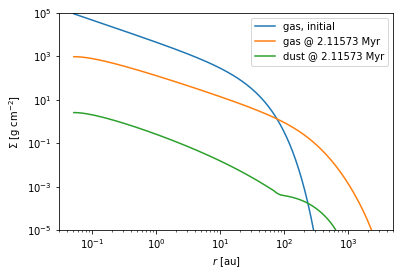

In [8]:
f,ax = plt.subplots()
ax.loglog(res.x/au,res.sigma_g[0],label='gas, initial')
ax.loglog(res.x/au,res.sigma_g[it],label='gas @ {:g} Myr'.format(res.timesteps[it]/1e6/year))
ax.loglog(res.x/au,res.sigma_d[it],label='dust @ {:g} Myr'.format(res.timesteps[it]/1e6/year))
ax.legend()
ax.set_ylim(1e-5,1e5)
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('$\Sigma$ [g cm$^{-2}$]');

## Dust size distributions

Reconstruct of the size distribution at the desired time

In [9]:
def get_distri(res,it):
    distri = twopoppy.distribution_reconstruction.reconstruct_size_distribution(
        res.x,
        res.a,
        res.timesteps[it],
        res.sigma_g[it],
        res.sigma_d[it],
        res.alpha*np.ones_like(res.x),
        res.args.rhos,
        res.T[it],
        res.args.mstar,
        res.args.vfrag,
        estick=res.args.estick,
        a_0=res.args.a0)

    return distri[:2]

sig_da,a_max = get_distri(res,it)

/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


Plot the reconstructed size distribution

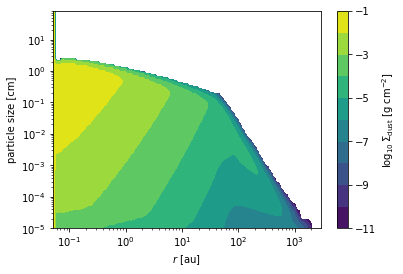

In [10]:
f,ax = plt.subplots()
ymax = np.ceil(np.log10(sig_da.max()))
cc=ax.contourf(res.x/au,res.a,np.log10(sig_da),np.arange(ymax-10,ymax+1))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('particle size [cm]')
cb=plt.colorbar(cc);
cb.set_label('$\log_{10}\,\Sigma_\mathrm{dust}$ [g cm$^{-2}$]');

## Calculate opacity

**Note:** this works only on my machine - the next code cell is for loading the opacities that I calculate here.

In [11]:
sys.path.append('/Users/birnstiel/Dropbox/python-projects/disk_pop_synth/')
import aux

rhos  = res.args.rhos
na_t  = len(res.a)*10
a     = np.logspace(np.log10(res.a[0]),np.log10(res.a[-1]),na_t)

# define the wavelength grid

lam = np.logspace(np.log10(c_light/700e9),np.log10(c_light/20e9),8)
lam = np.sort(np.append(lam,0.0880)) # add 880 micron to the grid

# calculate opacities

n_lam        = len(lam)
lam_mic      = lam*1e4
k_a,k_s,rhos = aux.get_opacities(a,lam_mic,density=rhos)

# smooth it

k_a = savgol_filter(k_a, int(na_t/100//2*2+1), 1, mode='interp',axis=0)
k_s = savgol_filter(k_s, int(na_t/100//2*2+1), 1, mode='interp',axis=0)

# interpolate it on the particle size used in the size reconstruction

k_a = np.array([10.**np.interp(np.log10(res.a),np.log10(a),np.log10(k)) for k in k_a.T]).T
k_s = np.array([10.**np.interp(np.log10(res.a),np.log10(a),np.log10(k)) for k in k_s.T]).T

# save it

np.savez('opacity',k_a=k_a, k_s=k_s, lam=lam, a=a)

Using Mie method MW
Mie ... Done!


Load the results if you cannot run my opacity helper functions

In [12]:
opacity = np.load('opacity.npz')

k_a  = opacity['k_a']
k_s  = opacity['k_s']
lam  = opacity['lam']
a    = opacity['a']
rhos = res.args.rhos

### Calculate optical depth and emission profiles

In [13]:
distance      = 140*pc
flux_fraction = 0.68

it     = np.abs(res.timesteps-sample_time).argmin()
T      = res.T[it]

# calculate planck function at every wavelength and radius

Bnu = planck_B_nu(c_light/(np.array(lam*1e4,ndmin=2).T*1e-4),np.array(T,ndmin=2)) # shape = (n_lam, n_r)

# calculate optical depth

tau = (k_a.T[:,:,np.newaxis]*sig_da[np.newaxis,:,:]) # shape = (n_l, n_a, n_r)
tau = tau.sum(1)                                 # shape = (n_l, n_r)

# calculate intensity at every wavelength and radius for this snapshot
# here the intensity is still in plain CGS units (per sterad)

intens = Bnu*(1-np.exp(-tau))

# calculate the fluxes and radii

flux   = distance**-2*cumtrapz(2*np.pi*res.x*intens,x=res.x,axis=1,initial=0) # integrated flux density
idx    = [np.where(_f/_f[-1]>=flux_fraction)[0][0] for _f in flux] # index of radius whithin which >=68% of the dust mass is
flux_t = flux[:,-1]/1e-23 # store the integrated flux density in Jy (sanity check: TW Hya @ 870 micron and 54 parsec is about 1.5 Jy)

# converted intensity to Jy/arcsec**2

Inu = intens * arcsec_sq/1e-23
rf  = res.x[idx]

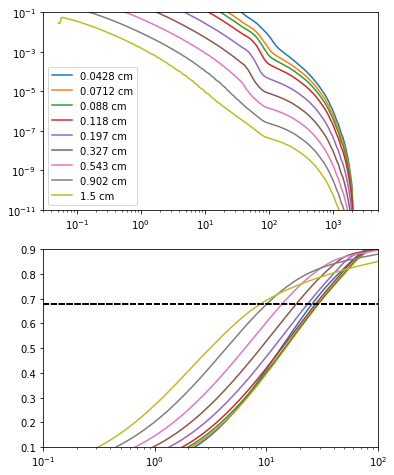

In [14]:
f,ax = plt.subplots(2,1,figsize=(6,8))

for i_lam in range(len(lam)):

    ax[0].loglog(res.x/au,Inu[i_lam],label='{:.3g} cm'.format(lam[i_lam]))

    cum = cumtrapz(2*np.pi*res.x*Inu[i_lam],x=res.x,initial=1e-10)
    cum = cum/cum[-1]
    ax[1].semilogx(res.x/au,cum)

    ax[1].axhline(flux_fraction,c='k',ls='--') 
    
ax[0].legend()
ax[0].set_ylim(1e-11,1e-1)
ax[1].set_ylim(0.1,0.9)
ax[1].set_xlim(1e-1,1e2);

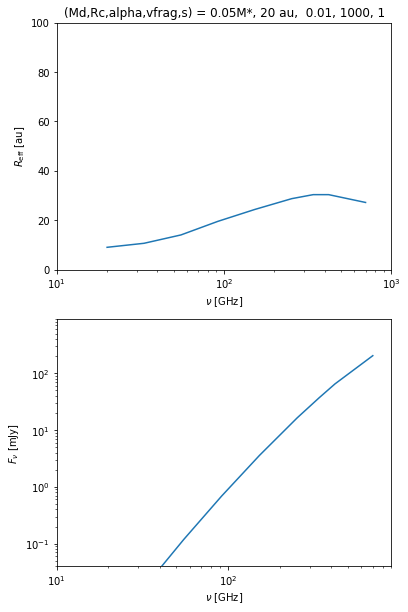

In [15]:
f,ax = plt.subplots(2,1,figsize=(6,10))
ax[0].semilogx(c_light/lam/1e9,rf/au)
ax[0].set_ylim(0,100)
ax[0].set_xlim(10,1000)
ax[0].set_xlabel(r'$\nu$ [GHz]')
ax[0].set_ylabel(r'$R_\mathrm{eff}$ [au]')
ax[1].loglog(c_light/lam/1e9,flux_t*1e3)
ax[1].set_ylim(4e-2,9e2)
ax[1].set_xlim(10,9e2)
ax[1].set_xlabel(r'$\nu$ [GHz]')
ax[1].set_ylabel(r'$F_\nu$ [mJy]')
ax[0].set_title('(Md,Rc,alpha,vfrag,s) = {:.4g}M*, {:.4g} au,  {:.4g}, {:.4g}, {:.4g}'.format(res.args.mdisk/res.args.mstar,res.args.rc/au,res.args.alpha,res.args.vfrag,res.args.estick));
f.savefig('fig1.pdf')

### Bonus: Reconstruct size distributions at different times and plot the time evolution

In [16]:
snapshots = np.array([1e5,5e5,1e6,2e6,3e6])*year
#snapshots = np.array([2e6*year])

SD = []

for time in snapshots:
    it = np.abs(res.timesteps-time).argmin()
    SD += [get_distri(res,it)]
    
sd  = SD[-1][0] # pick the last one as example

/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))
/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))
/Users/birnstiel/Dropbox/python-projects/twopoppy/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), n

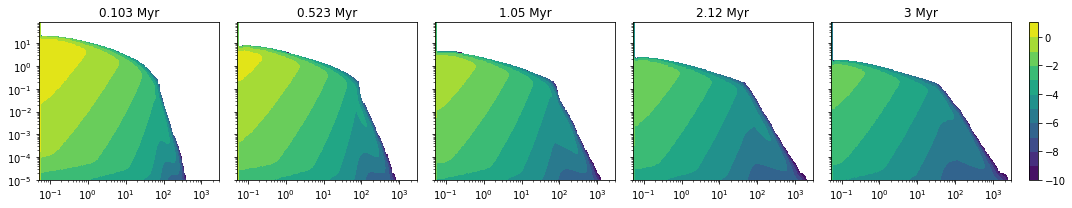

In [17]:
f = plt.figure(figsize=(3*len(snapshots),3))

gs = gridspec.GridSpec(1, len(snapshots)+1, width_ratios=[20]*len(snapshots)+[1])
ax1 = f.add_subplot(gs[0, 0])
axs = [ax1] + [f.add_subplot(gs[0, i],sharex=ax1, sharey=ax1) for i in np.arange(len(snapshots)-1)+1]
cax = f.add_subplot(gs[0, len(snapshots)])

for sd,time,ax in zip(SD,snapshots,axs):
    
    distri = sd[0]

    cc=ax.contourf(res.x/au,res.a,np.log10(distri+1e-100),np.arange(-10,2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('{:.3g} Myr'.format(res.timesteps[res.timesteps.searchsorted(time)]/1e6/year))
    plt.setp(ax.get_yticklabels(), visible=False)

plt.setp(axs[0].get_yticklabels(), visible=True)

plt.colorbar(cc,cax=cax);

f.tight_layout()

# Part 2: reading results from the table

In [18]:
fname = 'results_table.dat'

In [19]:
data = np.loadtxt(fname)

with open(fname) as f:
    header = f.readline()
columns = [_s.strip() for _s in header[2:].split(',')]

parameters,units = np.array([[c.split('[')[0].strip(),c.split('[')[1].strip()[:-1]] for c in columns]).T

# display contents

s=['Column Nr. | content | unit',':--|:--|--']
s+= ['{} | {} | {}'.format(i,v[0],v[1]) for i,v in enumerate(zip(parameters,units))]
display(Markdown('\n'.join(s)))

Column Nr. | content | unit
:--|:--|--
0 | wavelength | cm
1 | time | s
2 | stellar mass | g
3 | disk mass | g
4 | charact. radius | cm
5 | alpha | -
6 | fragmentation velocity | cm/s
7 | sticking probability | -
8 | integrated flux density | Jy
9 | 68% radius | cm

In [20]:
def get_values(i,data):
    param_values = list(set(data[:,i]))
    return sorted(param_values)

for i in range(7):
    print(parameters[i]+' ['+units[i]+']'+': '+', '.join(['{:.3g}'.format(d) for d in get_values(i,data)]))

wavelength [cm]: 0.0428, 0.0712, 0.088, 0.118, 0.197, 0.327, 0.543, 0.902, 1.5
time [s]: 3.16e+12, 1.58e+13, 3.16e+13, 6.31e+13, 9.47e+13
stellar mass [g]: 2.59e+33
disk mass [g]: 2.59e+31, 5.17e+31, 1.29e+32, 2.59e+32, 5.17e+32
charact. radius [cm]: 2.99e+14, 5.98e+14, 1.5e+15, 2.99e+15, 4.49e+15
alpha [-]: 0.0001, 0.001, 0.01
fragmentation velocity [cm/s]: 100, 500, 1e+03


Select the simulation with the specified values and display the text data

In [21]:
mask   = \
    np.isclose(data[:,5],sample_alpha) & \
    np.isclose(data[:,7],sample_estick) & \
    np.isclose(data[:,3]/data[:,2],sample_mratio) & \
    np.isclose(data[:,4],sample_rc) & \
    np.isclose(data[:,1],sample_time) & \
    np.isclose(data[:,6],sample_vfrag)
subset = data[mask,:]

In [22]:
for n,u,v in zip(parameters,units,subset[-1]):
    print('{}:'.format(n).ljust(25)+'{:<10.3g}{}'.format(v,u))

wavelength:              1.5       cm
time:                    6.31e+13  s
stellar mass:            2.59e+33  g
disk mass:               1.29e+32  g
charact. radius:         2.99e+14  cm
alpha:                   0.01      -
fragmentation velocity:  1e+03     cm/s
sticking probability:    1         -
integrated flux density: 1.78e-05  Jy
68% radius:              1.35e+14  cm


### Recreate the plot from above based on the results table

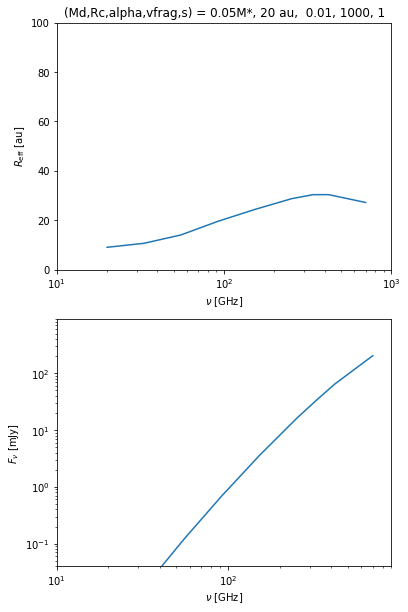

In [23]:
f,ax = plt.subplots(2,1,figsize=(6,10))
ax[0].semilogx(c_light/subset[:,0]/1e9,subset[:,-1]/au)
ax[0].set_ylim(0,100)
ax[0].set_xlim(10,1000)
ax[0].set_xlabel(r'$\nu$ [GHz]')
ax[0].set_ylabel(r'$R_\mathrm{eff}$ [au]')
ax[1].loglog(c_light/subset[:,0]/1e9,subset[:,-2]*1e3*(54/(140))**2) # rescaling due to different distance
ax[1].set_ylim(4e-2,9e2)
ax[1].set_xlim(10,9e2)
ax[1].set_xlabel(r'$\nu$ [GHz]')
ax[1].set_ylabel(r'$F_\nu$ [mJy]')
ax[0].set_title('(Md,Rc,alpha,vfrag,s) = {:.4g}M*, {:.4g} au,  {:.4g}, {:.4g}, {:.4g}'.format(subset[0,3]/subset[0,2],subset[0,4]/au,*subset[0,[5,6,7]]));
f.savefig('fig2.pdf')

### Plot the size-luminosity relation

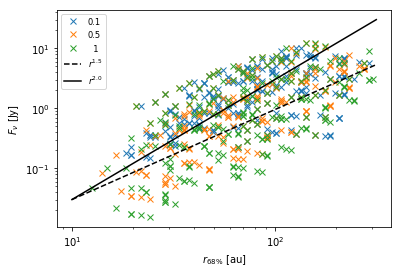

In [24]:
# pick a parameter to distinguish with colori in the plot
# this is the colmun number from the table above

i_value = 7

# pick all simulations with the same time and a given wavelenth

wlength = get_values(0,data)
times   = get_values(1,data)
it      = np.abs(np.array(times)-sample_time).argmin()
mask    = np.where( (data[:,1]==times[3]) & (data[:,0]==wlength[2]) )[0]
sample  = data[mask,:]


f,ax = plt.subplots()
values  = np.sort(list(set(data[:,i_value])))

for i,v in enumerate(values):
    mask = np.where(sample[:,i_value]==values[i])[0]
    ax.loglog(sample[mask,-1]/au,sample[mask,-2],'x',label='{:3.2g}'.format(v))
    
_r = np.logspace(1,2.5,100)
ax.loglog(_r,3e-2*(_r/_r[0])**1.5,'k--',label='$r^{1.5}$')
ax.loglog(_r,3e-2*(_r/_r[0])**2.0,'k-', label='$r^{2.0}$');
ax.legend(fontsize='small',loc='best');
ax.set_xlabel('$r_{68\%}$ [au]')
ax.set_ylabel('$F_\\nu$ [Jy]');